In [3]:
# import package
from tqdm import tqdm
import numpy as np
import random
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import string
from torch.utils.data import Dataset, DataLoader
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
nltk.download('stopwords')
nltk.download("wordnet")
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zhanh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zhanh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
import pandas as pd
# load
df = pd.read_csv('chatgpt_paraphrases.csv')
print(df.shape)
df

(419197, 4)


,text,paraphrases,category,source
0,What is the step by step guide to invest in sh...,['Can you provide a detailed procedure for inv...,question,quora
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,['Can you tell me about the history of the Koh...,question,quora
2,How can I increase the speed of my internet co...,['What are some ways to enhance my internet sp...,question,quora
3,Why am I mentally very lonely? How can I solve...,['What is causing my mental loneliness and how...,question,quora
4,"Which one dissolve in water quikly sugar, salt...","['Among sugar, salt, methane, and carbon dioxi...",question,quora
...,...,...,...,...
419192,He wants to see prices brought down across the...,['He desires a reduction in prices across all ...,sentence,cnn_news
419193,"Costs: The Department for Environment, Food an...","['The Department for Environment, Food and Rur...",sentence,cnn_news
419194,Details of the action on water bills are expec...,"[""Downing Street is expected to reveal specifi...",sentence,cnn_news
419195,Chancellor George Osborne signalled the govern...,"[""In a speech last month, Chancellor George Os...",sentence,cnn_news


In [5]:
# paraphrased label

category={}
for i in range(len(df)):
    chatgpt=df.iloc[i]["paraphrases"][1:-1].split(', ')
    for j in chatgpt[:1]:
        category[j[1:-1]]=1 # gpt
    category[df.iloc[i]['text']]=0 # human

combined_df=pd.DataFrame(category.items(),columns=["text","label"])
datcombined_dfa=combined_df.sample(frac=1)
combined_df=combined_df[:50000]
combined_df

,text,label
0,Can you provide a detailed procedure for inves...,1
1,What is the step by step guide to invest in sh...,0
2,Can you tell me about the history of the Kohin...,1
3,What is the story of Kohinoor (Koh-i-Noor) Dia...,0
4,What are some ways to enhance my internet spee...,1
...,...,...
49995,How can I not be an introvert?,0
49996,Can I speak to someone on the phone? I need to...,1
49997,I want to talk to someone or anyone on phone I...,0
49998,What is the equivalent number of ounces in one...,1


Text(0.5, 1.0, 'Data Distribution')

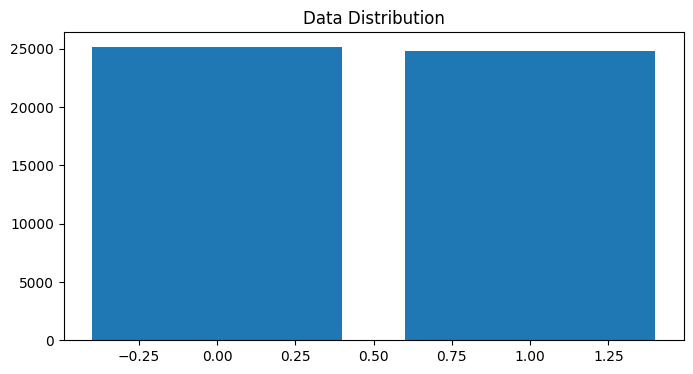

In [6]:
import matplotlib.pyplot as plt
val_count = combined_df.label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Data Distribution")

In [16]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
from nltk.stem import WordNetLemmatizer

# Function to remove emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', string)

# Function to clean a sentence
def clean_sentence(sentence):
    sentence = re.sub(r'http\S+', ' ', sentence)
    sentence = remove_emoji(sentence)
    sentence = re.sub("[^0-9A-Za-z ]", "", sentence)
    sentence = sentence.replace('  ', "")
    return sentence.strip()

# Function to remove stopwords
def remove_stopwords(tokens, stopwords):
    clean_token = [word for word in tokens if word not in stopwords]
    return clean_token

# Function for lemmatization
def lemmatize(tokens, lemma):
    lemmatized_tokens = [lemma.lemmatize(token, pos='v') for token in tokens]
    return lemmatized_tokens

# Function for truncating and padding
def trunc_padding(sentence, max_length):
    modify_sentence = sentence.copy()
    if len(modify_sentence) >= max_length:
        modify_sentence = modify_sentence[:max_length]
    else:
        modify_sentence.extend(list(["0"] * (max_length - len(modify_sentence))))
    return modify_sentence

# Main processing function
stopwords = nltk.corpus.stopwords.words('english')
lemma = WordNetLemmatizer()
max_length = 10  # You can adjust the maximum sentence length

combined_df['text'] = combined_df['text'].apply(lambda sentence: sentence.lower())
combined_df['text'] = combined_df['text'].apply(lambda sentence: clean_sentence(sentence))
combined_df['text'] = combined_df['text'].apply(lambda sentence: sentence.split())
combined_df['text'] = combined_df['text'].apply(lambda sentence: remove_stopwords(sentence, stopwords))
combined_df['text'] = combined_df['text'].apply(lambda sentence: lemmatize(sentence, lemma))
combined_df['text'] = combined_df['text'].apply(lambda sentence: trunc_padding(sentence, max_length))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zhanh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zhanh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Assuming your text data is in a DataFrame called combined_df with columns 'text' and 'label'
texts = combined_df['text'].values
binary_labels = combined_df['label'].values

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to ensure consistent length
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, binary_labels, test_size=0.2, random_state=42
)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Define the input layer
input_layer = Input(shape=(max_sequence_length,))

# Shared Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100)(input_layer)

# Encoder LSTM layer with dropout
encoder_lstm = LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)

# Repeat the encoder output for decoding
decoder_repeat = tf.keras.layers.RepeatVector(max_sequence_length)(encoder_lstm)

# Decoder LSTM layer
decoder_lstm = LSTM(units=128, return_sequences=True)(decoder_repeat)

# Dense layer for classification using the decoder output
output_layer = Dense(units=1, activation='sigmoid')(decoder_lstm)

# Create the model
encoder_decoder_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
encoder_decoder_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model

encoder_decoder_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))



Epoch 1/30


1250/1250 [==============================] - 54s 41ms/step - loss: 0.4633 - accuracy: 0.7821 - val_loss: 0.4282 - val_accuracy: 0.8016
Epoch 2/30
1250/1250 [==============================] - 52s 41ms/step - loss: 0.3533 - accuracy: 0.8486 - val_loss: 0.4459 - val_accuracy: 0.7991
Epoch 3/30
1250/1250 [==============================] - 52s 42ms/step - loss: 0.2838 - accuracy: 0.8783 - val_loss: 0.5435 - val_accuracy: 0.7893
Epoch 4/30
1250/1250 [==============================] - 50s 40ms/step - loss: 0.2233 - accuracy: 0.9038 - val_loss: 0.6000 - val_accuracy: 0.7816
Epoch 5/30
1250/1250 [==============================] - 51s 41ms/step - loss: 0.1769 - accuracy: 0.9257 - val_loss: 0.6775 - val_accuracy: 0.7763
Epoch 6/30
1250/1250 [==============================] - 57s 46ms/step - loss: 0.1444 - accuracy: 0.9413 - val_loss: 0.7404 - val_accuracy: 0.7667
Epoch 7/30
1250/1250 [==============================] - 57s 45ms/step - loss: 0.1171 - accuracy: 0.9531 - val_loss: 0.85

In [3]:
import pandas as pd
test = pd.read_csv('stm_test.csv')

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Extracting the true labels and predicted targets
y_true = test['label']
y_pred = test['target']

# Calculating the evaluation metrics
conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

# Extracting False Positives and False Negatives from the confusion matrix
# conf_matrix = [ [TN, FP]
#                 [FN, TP] ]
fp = conf_matrix[0][1]
fn = conf_matrix[1][0]

# Compiling the results
results = {
    "Confusion Matrix": conf_matrix,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC Score": roc_auc,
    "False Positives (FP)": fp,
    "False Negatives (FN)": fn
}

results


{'Confusion Matrix': array([[3765, 1285],
        [ 920, 4030]], dtype=int64),
 'Accuracy': 0.7644,
 'Precision': 0.7582314205079962,
 'Recall': 0.7541414141414142,
 'F1 Score': 0.7851924013638578,
 'ROC AUC Score': 0.7798429842984299,
 'False Positives (FP)': 1285,
 'False Negatives (FN)': 920}